In [40]:
import os, sys, time, pickle, glob
from pathlib import Path

# numpy to SITK conversion
import torch
import numpy     as np
import SimpleITK as sitk

# meshio for 3DSlicer segm obj
import meshio


# segmentation
from scipy.spatial   import Delaunay
    

# hardware stats
import GPUtil as GPU

# plot
from helpers.viz import viz_axis, viz_compare_inputs, viz_compare_outputs
from helpers.viz import *


# Segm Obj -> SITK

# 1. Get affine matrix in SITK
# https://niftynet.readthedocs.io/en/v0.2.2/_modules/niftynet/io/simple_itk_as_nibabel.html
def make_affine(simpleITKImage, ras_adj):
    # get affine transform in LPS
    c = [simpleITKImage.TransformIndexToPhysicalPoint(p)
         for p in ((1, 0, 0),
                   (0, 1, 0),
                   (0, 0, 1),
                   (0, 0, 0))]
    c = np.array(c)
    affine = np.concatenate([
        np.concatenate([c[0:3] - c[3:], c[3:]], axis=0),
        [[0.], [0.], [0.], [1.]]
    ], axis=1)
    affine = np.transpose(affine)
    # convert to RAS to match nibabel
    if ras_adj:
        affine = np.matmul(np.diag([-1., -1., 1., 1.]), affine)
    return affine

    
# sitk obj and np array have different index conventions
# deep copy
def sitk2np(obj): return np.swapaxes(sitk.GetArrayFromImage(obj), 0, 2)
def np2sitk(arr): return sitk.GetImageFromArray(np.swapaxes(arr, 0, 2))

def torch2sitk(t): return sitk.GetImageFromArray(torch.transpose(t, 0, 2))
def sitk2torch(o): return torch.transpose(torch.tensor(sitk.GetArrayFromImage(o)), 0, 2)



# Viz data

Souces:

- https://colab.research.google.com/github/hardik0/AI-for-Medicine-Specialization/blob/master/AI-for-Medical-Diagnosis/Week-3/Explore_MRI_data.ipynb#scrollTo=nLgMNEFolcHr

In [1]:
# set root directory of data
DATA = "/home/gologors/data/"


In [2]:
# utilities
import os, sys, time, json

# graphing
from matplotlib import gridspec, colors

import matplotlib.pyplot as plt
import seaborn as sns

# data
import numpy as np
import pandas as pd

# nii
import SimpleITK as sitk

# interactive
from ipywidgets import interact, interactive, IntSlider, ToggleButtons, fixed

# helpers

# add root to filepath (=os.path.join)
def getfp(fn, root=DATA): return f"{root}/{fn}"

# sitk obj and np array have different index conventions
# deep copy
def sitk2np(obj): return np.swapaxes(sitk.GetArrayFromImage(obj), 0, 2)
def np2sitk(arr): return sitk.GetImageFromArray(np.swapaxes(arr, 0, 2))

# round all floats in a tuple to 3 decimal places
def round_tuple(t, d=2): return tuple(round(x,d) for x in t)

def orient_test(image):
    orient = sitk.DICOMOrientImageFilter()
    orient.DebugOn()
    print(round_tuple(image.GetDirection(), d=2))
    print(orient.GetOrientationFromDirectionCosines(image.GetDirection()))

# print sitk info
def print_sitk_info(image):   
    orient = sitk.DICOMOrientImageFilter()

    print("Size: ", image.GetSize())
    print("Origin: ", image.GetOrigin())
    print("Spacing: ", image.GetSpacing())
    print("Direction: ", round_tuple(image.GetDirection(), d=2))
    print("Orientation: ", orient.GetOrientationFromDirectionCosines(image.GetDirection()))
    print(f"Pixel type: {image.GetPixelIDValue()} = {image.GetPixelIDTypeAsString()}")

# Sequences to align

We align the following: Cor T1, Cor T2, +Cor T1 (i.e. with contrast).

1. Get .niis associated w/ seq
2. Convert .nii to sitk obj
    - re-orient to LAS
    - crop to foreground via threshold
3. Resample all sitk objs to same reference frame
4. Elastix rigid align (Euler transform) via reg.py

In [4]:
import os
print(len(os.listdir("/home/gologors/data/pitmri/las_pt")))

774


In [110]:
def fp2sitk(fp):
    """ Orient to LAS & Crop to Foreground """
    im_obj = sitk.ReadImage(fp)
    return threshold_based_crop(sitk.DICOMOrient(im_obj, "LAS"))
    
# Crop https://github.com/SimpleITK/ISBI2018_TUTORIAL/blob/master/python/03_data_augmentation.ipynb
def threshold_based_crop(image):
    '''
    Use Otsu's threshold estimator to separate background and foreground. In medical imaging the background is
    usually air. Then crop the image using the foreground's axis aligned bounding box.
    Args:
        image (SimpleITK image): An image where the anatomy and background intensities form a bi-modal distribution
                                 (the assumption underlying Otsu's method.)
    Return:
        Cropped image based on foreground's axis aligned bounding box.  
    '''
    # Set pixels that are in [min_intensity,otsu_threshold] to inside_value, values above otsu_threshold are
    # set to outside_value. The anatomy has higher intensity values than the background, so it is outside.
    inside_value = 0
    outside_value = 255
    label_shape_filter = sitk.LabelShapeStatisticsImageFilter()
    label_shape_filter.Execute( sitk.OtsuThreshold(image, inside_value, outside_value) )
    bounding_box = label_shape_filter.GetBoundingBox(outside_value)
    # The bounding box's first "dim" entries are the starting index and last "dim" entries the size
    return sitk.RegionOfInterest(image, bounding_box[int(len(bounding_box)/2):], bounding_box[0:int(len(bounding_box)/2)])

# get standard reference domain

# src: https://github.com/SimpleITK/ISBI2018_TUTORIAL/blob/master/python/03_data_augmentation.ipynb
def get_reference_frame(img_data, new_spacing):
    #img_data = [(o.GetSize(), o.GetSpacing()) for o in objs]

    dimension = 3 # 3D MRs
    pixel_id = 8 # 2 = 16-bit signed integer

    # Physical image size corresponds to the largest physical size in the training set, or any other arbitrary size.
    reference_physical_size = np.zeros(dimension)

    for img_sz, img_spc in img_data:
        reference_physical_size[:] = [(sz-1)*spc if sz*spc>mx else mx \
                                      for sz, spc, mx in zip(img_sz, img_spc, reference_physical_size)]

    # Create the reference image with a zero origin, identity direction cosine matrix and dimension     
    reference_origin = np.zeros(dimension)
    reference_direction = np.identity(dimension).flatten()

    # Non-Isotropic pixels
    reference_spacing = new_spacing
    reference_size = [int(phys_sz/(spc) + 1) for phys_sz,spc in zip(reference_physical_size, reference_spacing)]

    # Set reference image attributes
    reference_image = sitk.Image(reference_size, pixel_id)
    reference_image.SetOrigin(reference_origin)
    reference_image.SetSpacing(reference_spacing)
    reference_image.SetDirection(reference_direction)

    reference_center = np.array(reference_image.TransformContinuousIndexToPhysicalPoint(np.array(reference_image.GetSize())/2.0))
    return reference_image, (reference_size, pixel_id, reference_origin, reference_spacing, reference_direction, reference_center)

def get_reference_image(reference_frame):
    reference_size, pixel_id, reference_origin, reference_spacing, reference_direction, reference_center = reference_frame
    reference_image = sitk.Image(reference_size, pixel_id)
    reference_image.SetOrigin(reference_origin)
    reference_image.SetSpacing(reference_spacing)
    reference_image.SetDirection(reference_direction)
    return reference_image, reference_center

def resample2reference(img, reference_image, reference_center, \
                       interpolator = sitk.sitkLinear, default_intensity_value = 0.0, dimension=3):
    
    # Define translation transform mapping origins from reference_image to the current img
    transform = sitk.AffineTransform(dimension)
    transform.SetMatrix(img.GetDirection())
    transform.SetTranslation(np.array(img.GetOrigin()) - reference_image.GetOrigin())
    
    # Modify the transformation to align the centers of the original and reference image instead of their origins.
    centering_transform = sitk.TranslationTransform(dimension)
    img_center = np.array(img.TransformContinuousIndexToPhysicalPoint(np.array(img.GetSize())/2.0))
    centering_transform.SetOffset(np.array(transform.GetInverse().TransformPoint(img_center) - reference_center))
    
    centered_transform = sitk.CompositeTransform([centering_transform])
    
#     centered_transform = sitk.Transform(transform)
#     centered_transform.AddTransform(centering_transform)
    
    return sitk.Resample(img, reference_image, centered_transform, interpolator, default_intensity_value, img.GetPixelID())

In [29]:
import pickle
from pathlib import Path

root = "/home/gologors/data/"

with open(root + 'pitmri/' + 'all_filenames.pkl', 'rb') as f: 
    pit_filenames = pickle.load(f)

In [30]:
reader = sitk.ImageFileReader()

reader.SetFileName(pit_filenames[0][0])
reader.ReadImageInformation()

for k in reader.GetMetaDataKeys():
    v = reader.GetMetaData(k)
    print(f"({k}) = = \"{v}\"")

print(f"Image Size: {reader.GetSize()}")
print(f"Image PixelType: {sitk.GetPixelIDValueAsString(reader.GetPixelID())}")

print(reader.GetSize(), reader.GetSpacing())
#  img_data = [(o.GetSize(), o.GetSpacing()) for o in objs]



(ITK_FileNotes) = = "TE=16;Time=15212.290"
(aux_file) = = ""
(bitpix) = = "16"
(cal_max) = = "0"
(cal_min) = = "0"
(datatype) = = "4"
(descrip) = = "TE=16;Time=15212.290"
(dim[0]) = = "3"
(dim[1]) = = "512"
(dim[2]) = = "512"
(dim[3]) = = "16"
(dim[4]) = = "1"
(dim[5]) = = "1"
(dim[6]) = = "1"
(dim[7]) = = "1"
(dim_info) = = "54"
(intent_code) = = "0"
(intent_name) = = ""
(intent_p1) = = "0"
(intent_p2) = = "0"
(intent_p3) = = "0"
(nifti_type) = = "1"
(pixdim[0]) = = "0"
(pixdim[1]) = = "0.410156"
(pixdim[2]) = = "0.410156"
(pixdim[3]) = = "3"
(pixdim[4]) = = "0.458827"
(pixdim[5]) = = "0"
(pixdim[6]) = = "0"
(pixdim[7]) = = "0"
(qform_code) = = "1"
(qform_code_name) = = "NIFTI_XFORM_SCANNER_ANAT"
(qoffset_x) = = "106.335"
(qoffset_y) = = "41.3455"
(qoffset_z) = = "-128.695"
(quatern_b) = = "0.0638872"
(quatern_c) = = "-0.754762"
(quatern_d) = = "-0.652643"
(scl_inter) = = "0"
(scl_slope) = = "5.44737"
(sform_code) = = "1"
(sform_code_name) = = "NIFTI_XFORM_SCANNER_ANAT"
(slice_code) =

In [31]:
def get_stem_name(fn):
    basename = os.path.basename(fn)
    return basename[:basename.index(".nii")]

In [32]:
def get_im_data(fn):
    reader = sitk.ImageFileReader()

    reader.SetFileName(fn)
    reader.ReadImageInformation()

#     for k in reader.GetMetaDataKeys():
#         v = reader.GetMetaData(k)
#         print(f"({k}) = = \"{v}\"")

#     print(f"Image Size: {reader.GetSize()}")
#     print(f"Image PixelType: {sitk.GetPixelIDValueAsString(reader.GetPixelID())}")

    return (reader.GetSize(), reader.GetSpacing())

In [118]:
import pickle
from pathlib import Path

root = "/home/gologors/data/"

with open(root + 'pitmri/' + 'all_loni_filenames.pkl', 'rb') as f: 
    loni_filenames = pickle.load(f)
    
fps = {get_stem_name(im_fn):im_fn for im_fn, seg_fn in loni_filenames}

im_data = [get_im_data(im_fn) for im_fn, seg_fn in loni_filenames[:50]]

# resample to same domain
new_spacing = (0.41015625, 0.41015625, 3.0)
loni_reference_image, loni_reference_frame = get_reference_frame(im_data, new_spacing)

# unpack reference frame
reference_size, pixel_id, reference_origin, reference_spacing, reference_direction, reference_center = reference_frame

# print
print("Loni Reference Image")
print_sitk_info(loni_reference_image)

# for im_fn, seg_fn in pit_filenames:
#     print(get_stem_name(im_fn))

Loni Reference Image
Size:  (505, 654, 90)
Origin:  (0.0, 0.0, 0.0)
Spacing:  (0.41015625, 0.41015625, 3.0)
Direction:  (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
Orientation:  LPS
Pixel type: 8 = 32-bit float


In [117]:
fps = {get_stem_name(im_fn):im_fn for im_fn, seg_fn in pit_filenames}

im_data = [get_im_data(im_fn) for im_fn, seg_fn in pit_filenames]

# resample to same domain
new_spacing = (0.41015625, 0.41015625, 3.0)
reference_image, reference_frame = get_reference_frame(im_data, new_spacing)

# unpack reference frame
reference_size, pixel_id, reference_origin, reference_spacing, reference_direction, reference_center = reference_frame

# print
print("Reference Image")
print_sitk_info(reference_image)

# for im_fn, seg_fn in pit_filenames:
#     print(get_stem_name(im_fn))

Reference Image
Size:  (512, 535, 63)
Origin:  (0.0, 0.0, 0.0)
Spacing:  (0.41015625, 0.41015625, 3.0)
Direction:  (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
Orientation:  LPS
Pixel type: 8 = 32-bit float


In [119]:
im_data # loni

[((208, 256, 176), (1.0, 1.0, 1.0)),
 ((160, 239, 200), (1.100000023841858, 1.0, 1.0)),
 ((176, 256, 256), (1.0500000715255737, 1.05078125, 1.05078125)),
 ((208, 256, 176), (1.0, 1.0, 1.0)),
 ((208, 256, 176), (1.0, 1.0, 1.0)),
 ((176, 256, 256), (1.0500000715255737, 1.05078125, 1.05078125)),
 ((176, 256, 256), (1.0500000715255737, 1.05078125, 1.05078125)),
 ((176, 256, 256), (1.0500000715255737, 1.05078125, 1.05078125)),
 ((176, 256, 256), (1.0500000715255737, 1.05078125, 1.05078125)),
 ((176, 256, 256), (1.0500000715255737, 1.05078125, 1.05078125)),
 ((208, 256, 176), (1.0, 1.0, 1.0)),
 ((208, 256, 176), (1.0, 1.0, 1.0)),
 ((176, 256, 256), (1.0500000715255737, 1.05078125, 1.05078125)),
 ((176, 256, 256), (1.0500000715255737, 1.05078125, 1.05078125)),
 ((176, 256, 256), (1.0500000715255737, 1.05078125, 1.05078125)),
 ((160, 238, 200), (1.100000023841858, 1.0, 1.0)),
 ((176, 256, 256), (1.0500000715255737, 1.05078125, 1.05078125)),
 ((160, 239, 200), (1.100000023841858, 1.0, 1.0)),
 (

In [116]:
im_data

[((512, 512, 16), (0.41015625, 0.41015625, 3.0)),
 ((320, 320, 14), (0.40625, 0.40625, 2.75)),
 ((512, 512, 18), (0.41015625, 0.41015625, 3.0)),
 ((512, 512, 14), (0.37109375, 0.37109375, 2.5)),
 ((432, 432, 24), (0.4166666567325592, 0.4166666567325592, 2.200000047683716)),
 ((256, 256, 24), (0.625, 0.625, 3.0)),
 ((512, 512, 17), (0.41015625, 0.41015625, 3.0)),
 ((256, 256, 11), (0.5859375, 0.5859375, 4.0)),
 ((512, 512, 16), (0.41015625, 0.41015625, 3.0)),
 ((432, 432, 18), (0.4166666567325592, 0.4166666567325592, 2.200000047683716)),
 ((512, 512, 18), (0.41015625, 0.41015625, 3.0)),
 ((512, 512, 16), (0.41015625, 0.41015625, 3.0)),
 ((512, 512, 16), (0.3125, 0.3125, 3.0)),
 ((300, 384, 15), (0.5208333134651184, 0.5208333134651184, 2.0)),
 ((512, 512, 16), (0.41015625, 0.41015625, 3.0)),
 ((336, 336, 14), (0.5357142686843872, 0.5357142686843872, 3.299999952316284)),
 ((512, 512, 17), (0.3125, 0.3125, 3.990000009536743)),
 ((512, 512, 18), (0.3515999913215637, 0.3515999913215637, 3.29

In [121]:
i = 0

for im_fn, lbl_fn in pit_filenames:
    # Read in fns
    im         = sitk.ReadImage(im_fn, sitk.sitkFloat32)
    lbl_mesh   = meshio.read(lbl_fn)

    # Mesh -> boolean array (Delauney triangulation)
    dims    = im.GetSize()
    aff     = make_affine(im, ras_adj=False)
    idx_pts = np.indices(dims[::-1], dtype=np.uint16).T.reshape(-1,3)[:,[2,1,0]]
    physical_pts = (np.dot(aff[:3,:3], idx_pts.T) + aff[:3,3:4]).T 
    
    lbl_arr = (Delaunay(lbl_mesh.points).find_simplex(physical_pts) >= 0).reshape(dims)

    # Boolean arr -> SITK w/ same 
    lbl = sitk.GetImageFromArray(np.swapaxes(lbl_arr.astype(np.uint8), 0, 2))
    lbl.SetOrigin(im.GetOrigin())
    lbl.SetSpacing(im.GetSpacing())   
    lbl.SetDirection(im.GetDirection())
    
    # Recenter
    im  = resample2reference(im, reference_image, reference_center)
    lbl = resample2reference(lbl, reference_image, reference_center)
    
    # Re-orient to LAS
    im = sitk.DICOMOrient(im, "LAS")
    lbl = sitk.DICOMOrient(lbl, "LAS")
    
    # Save as pytorch tensor
    lbl_pt = sitk2torch(lbl)
    im_pt  = sitk2torch(im)
    
    basename = get_stem_name(im_fn)
    torch.save(im_pt, root + 'pitmri/resampled_pit/im_' + basename + '.pt')
    torch.save(lbl_pt, root + 'pitmri/resampled_pit/lbl_' + basename + '.pt')
    
    # Counter
    print(f"Done {i}")
    i += 1
    
    # break
    if i == 3:
        break

Done 0
Done 1
Done 2


# Test

In [124]:
resampled_pits = []

i = 0
for im_fn, lbl_fn in pit_filenames:
    
    basename = get_stem_name(im_fn)
    resampled_pits.append('pitmri/resampled_pit/im_' + basename + '.pt')
    # Counter
    print(f"Done {i}")
    i += 1
    
    # break
    if i == 3:
        break

Done 0
Done 1
Done 2


In [125]:
# resampled_pits = list(os.listdir(root + 'pitmri/' + 'resampled_pit/'))
# resampled_lonis = list(os.listdir(root + 'pitmri/' + 'resampled_loni/'))
                       
# print(len(resampled_pits), len(resampled_lonis))

In [126]:
resampled_pits

['pitmri/resampled_pit/im_1.3.46.670589.11.37169.5.0.8820.2016110101521229038_COR_T1_CLEAR_20161101012852_701.pt',
 'pitmri/resampled_pit/im_2.25.136122090940539320905329439584917076786_PIT_COR_T1_F_S_PRE_20161208123708_901.pt',
 'pitmri/resampled_pit/im_1.3.46.670589.11.37169.5.0.3436.2016110300230654926_COR_T1_CLEAR_20161103000404_701.pt']

In [93]:
for im_fn, lbl_fn in pit_filenames:
    # Read in fns
    im         = sitk.ReadImage(im_fn, sitk.sitkFloat32)
    lbl_mesh   = meshio.read(lbl_fn)

    # Mesh -> boolean array (Delauney triangulation)
    dims    = im.GetSize()
    aff     = make_affine(im, ras_adj=False)
    idx_pts = np.indices(dims[::-1], dtype=np.uint16).T.reshape(-1,3)[:,[2,1,0]]
    physical_pts = (np.dot(aff[:3,:3], idx_pts.T) + aff[:3,3:4]).T 
    
    lbl_arr = (Delaunay(lbl_mesh.points).find_simplex(physical_pts) >= 0).reshape(dims)

    # Boolean arr -> SITK w/ same 
    lbl = sitk.GetImageFromArray(np.swapaxes(lbl_arr.astype(np.uint8), 0, 2))
    lbl.SetOrigin(im.GetOrigin())
    lbl.SetSpacing(im.GetSpacing())   
    lbl.SetDirection(im.GetDirection())
    
    # Recenter
    im  = resample2reference(im, reference_image, reference_center)
    lbl = resample2reference(lbl, reference_image, reference_center)
    
    break

In [127]:
imnp = sitk2np(im)
imor = sitk2np(sitk.ReadImage(im_fn, sitk.sitkFloat32))

ims = [imor, imnp]
seqs = ["Pit 1", "Pit 2", "Loni 1", "Loni 2"]

In [128]:
print_sitk_info(sitk.ReadImage(im_fn, sitk.sitkFloat32))

Size:  (512, 512, 18)
Origin:  (-100.11138916015625, -40.95394515991211, -132.76080322265625)
Spacing:  (0.41015625, 0.41015625, 3.0)
Direction:  (0.99, -0.05, 0.15, -0.14, 0.11, 0.98, 0.07, 0.99, -0.1)
Orientation:  LSP
Pixel type: 8 = 32-bit float


In [129]:
print_sitk_info(reference_image)

Size:  (512, 535, 63)
Origin:  (0.0, 0.0, 0.0)
Spacing:  (0.41015625, 0.41015625, 3.0)
Direction:  (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
Orientation:  LPS
Pixel type: 8 = 32-bit float


In [130]:
print_sitk_info(im)

Size:  (512, 535, 63)
Origin:  (0.0, 219.0234375, 0.0)
Spacing:  (0.41015625, 0.41015625, 3.0)
Direction:  (1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 1.0)
Orientation:  LAS
Pixel type: 8 = 32-bit float


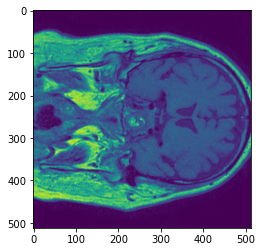

In [131]:
plt.imshow(imor[:,:,10])

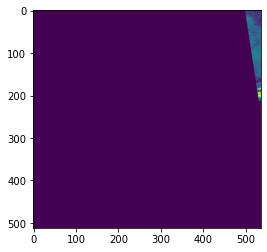

In [134]:
plt.imshow(imnp[:,:,20])

In [61]:
sample1 = [resampled_pits[10], resampled_pits[16]]
sample2 = resampled_lonis[0:2]

sample1 = [root + 'pitmri/' + 'resampled_pit/' + x for x in sample1]
sample2 = [root + 'pitmri/' + 'resampled_loni/' + x for x in sample2]

In [62]:
ims = [torch.load(x).numpy() for x in sample1 + sample2]
seqs = ["Pit 1", "Pit 2", "Loni 1", "Loni 2"]

In [46]:
sample2

['im_ABIDE_50055_MRI_MP-RAGE_br_raw_20120830220404875_S165229_I329239.pt',
 'im_ABIDE_50128_MRI_MP-RAGE_br_raw_20120830191737018_S164908_I328918.pt']

In [12]:
# # fps  = {seq:seq2fp(seq) for seq in seqs}
# objs = {seq:fp2sitk(fp) for seq,fp in fps.items()}

In [27]:
# for seq,obj in objs.items():
#     print("*"*50)
#     print(seq)
#     print_sitk_info(obj)
#     print("*"*50)

**************************************************
COR T1
Size:  (380, 17, 484)
Origin:  (-98.93094815072925, 15.964123981760224, -110.72881635369274)
Spacing:  (0.41015625, 3.0, 0.41015625)
Direction:  (0.98, 0.09, 0.15, 0.08, -0.99, 0.06, -0.15, 0.04, 0.99)
Orientation:  LAS
Pixel type: 8 = 32-bit float
**************************************************
**************************************************
COR T2
Size:  (356, 17, 454)
Origin:  (-98.94240546854581, 15.963736497488119, -110.7132399431765)
Spacing:  (0.4375, 3.0, 0.4375)
Direction:  (0.98, 0.09, 0.15, 0.08, -0.99, 0.06, -0.15, 0.04, 0.99)
Orientation:  LAS
Pixel type: 8 = 32-bit float
**************************************************
**************************************************
+COR T1
Size:  (383, 17, 489)
Origin:  (-99.33489810000317, 15.92953018699912, -110.66672080425725)
Spacing:  (0.41015625, 3.0, 0.41015625)
Direction:  (0.98, 0.09, 0.15, 0.08, -0.99, 0.06, -0.15, 0.04, 0.99)
Orientation:  LAS
Pixel type: 8 =

In [32]:
# resample to same domain
new_spacing = (0.41015625, 3.0, 0.41015625)
reference_image, reference_frame = get_reference_frame(fps, new_spacing)

# unpack reference frame
reference_size, pixel_id, reference_origin, reference_spacing, reference_direction, reference_center = reference_frame

# print
print("Reference Image")
print_sitk_info(reference_image)

Reference Image
Size:  (383, 17, 489)
Origin:  (0.0, 0.0, 0.0)
Spacing:  (0.41015625, 3.0, 0.41015625)
Direction:  (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
Orientation:  LPS
Pixel type: 8 = 32-bit float


In [ ]:
Reference Image
Size:  (512, 74, 460)
Origin:  (0.0, 0.0, 0.0)
Spacing:  (0.41015625, 3.0, 0.41015625)
Direction:  (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
Orientation:  LPS
Pixel type: 8 = 32-bit float
    
Loni Reference Image
Size:  (632, 90, 652)
Origin:  (0.0, 0.0, 0.0)
Spacing:  (0.41015625, 3.0, 0.41015625)
Direction:  (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
Orientation:  LPS
Pixel type: 8 = 32-bit float

In [40]:
# resample to reference
resampled_objs = {seq:resample2reference(o, reference_image, reference_center) for seq,o in objs.items()}

In [41]:
for seq,obj in resampled_objs.items():
    print("*"*50)
    print(seq)
    print_sitk_info(obj)
    print("*"*50)

**************************************************
COR T1
Size:  (383, 17, 489)
Origin:  (0.0, 0.0, 0.0)
Spacing:  (0.41015625, 3.0, 0.41015625)
Direction:  (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
Orientation:  LPS
Pixel type: 8 = 32-bit float
**************************************************
**************************************************
COR T2
Size:  (383, 17, 489)
Origin:  (0.0, 0.0, 0.0)
Spacing:  (0.41015625, 3.0, 0.41015625)
Direction:  (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
Orientation:  LPS
Pixel type: 8 = 32-bit float
**************************************************
**************************************************
+COR T1
Size:  (383, 17, 489)
Origin:  (0.0, 0.0, 0.0)
Spacing:  (0.41015625, 3.0, 0.41015625)
Direction:  (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
Orientation:  LPS
Pixel type: 8 = 32-bit float
**************************************************


In [5]:
def get_arr(seq):
    # get filepath to sequence
    seq_idx = series_info.loc[:,5] == seq
    fn      = series_info.loc[seq_idx,1].values[0]
    
    # get files in dir
    all_files = sorted(os.listdir(getfp(fn)))
    niis  = [x for x in all_files if x.endswith(".nii.gz")]
    jsons = [x for x in all_files if x.endswith(".json")] 
    dcms  = [x for x in all_files if x.endswith(".dcm")]
    
    # check if more than one
    if len(niis) != 1:
        print(f"Nii isn't unique! {seq}")
        
    # open .nii files
    im_obj = sitk.ReadImage(getfp(f"{fn}/{niis[0]}"))
    
    # reorient to LAS
    im_obj = sitk.DICOMOrient(im_obj, "LAS")
        
    im_arr = sitk2np(im_obj)
    
    return im_arr

In [6]:
ims = [get_arr(seq) for seq in seqs]

In [75]:
print(seqs)

['Pit 1', 'Pit 2', 'Loni 1', 'Loni 2']


In [76]:
for im in ims:
    print(im.shape)

(512, 74, 460)
(512, 74, 460)
(512, 74, 460)
(512, 74, 460)


In [92]:
plt.imshow(ims[4][:,67,:])

IndexError: list index out of range

In [63]:
axis = 1
nslices = ims[0].shape[axis]

print(nslices)

74
The history saving thread hit an unexpected error (OperationalError('unable to open database file')).History will not be written to the database.


# Pre-Alignment

In [71]:
def to_binary_im(img, threshold=150):
    # make all pixels < threshold black
    binarized = 1.0 * (img > threshold)
    
    return binarized

def get_binary_cm(col1="white", col2="red"): return colors.ListedColormap([col1, col2])

seq_colors = ["red", "green", "blue", "yellow", "orange"]

In [72]:
nslices

74

IndexError: index 5 is out of bounds for axis 0 with size 5

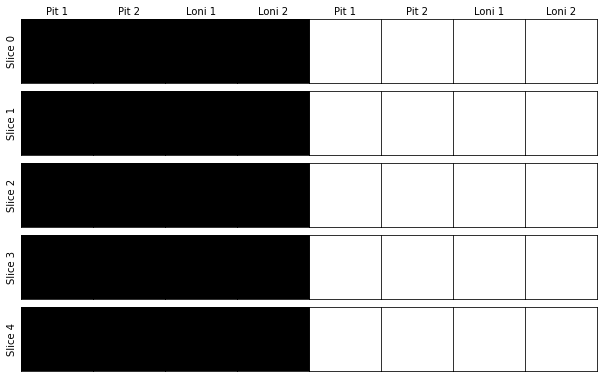

In [74]:
ncols = len(ims) + len(ims) + 1

nslices = 30

nrows = nrows # nslices

# fig options
fig_mult = 1
options = {
    "wspace": 0.0,
    "hspace": 0.0,
}

fig = plt.figure(figsize=(fig_mult*(ncols+1), fig_mult*(nrows+1))) 
gs  = gridspec.GridSpec(nrows, ncols,
        wspace=options["wspace"], hspace=options["hspace"], 
        top=1.-0.5/(nrows+1), bottom=0.5/(nrows+1), 
        left=0.5/(ncols+1), right=1-0.5/(ncols+1)) 
    
for row_idx, slice_idx in enumerate(range(nslices)):
    for col_idx, im_arr in enumerate(ims):
        im = np.take(im_arr, slice_idx, axis=axis)
        
        # plot original slice
        ax = plt.subplot(gs[row_idx,col_idx])
        ax.imshow(np.rot90(im), cmap=plt.cm.gray)
        
        # plot binary cmaps
        ax_next = plt.subplot(gs[row_idx,col_idx+len(ims)])
        ax_next.imshow(np.rot90(to_binary_im(im)), cmap=get_binary_cm(col2=seq_colors[col_idx]))
        
        # label the columns top of the plot
        if row_idx == 0:
            ax.set_xlabel(f'{seqs[col_idx]}')    
            ax.xaxis.set_label_position('top') 
            
            ax_next.set_xlabel(f'{seqs[col_idx]}')    
            ax_next.xaxis.set_label_position('top') 
        
        if col_idx == 0:
            # label the rows on the left side of the plot
            ax.set_ylabel(f'Slice {row_idx}')    
            ax.yaxis.set_label_position('left') 
            
        # remove tick marks
        ax.set_xticks([])
        ax.set_yticks([])
        
        ax_next.set_xticks([])
        ax_next.set_yticks([])
        
# plot last col w/ all binary maps overlaid
for row_idx, slice_idx in enumerate(range(nslices)):
        
        im_slices = [np.take(to_binary_im(im_arr), slice_idx, axis=axis) for im_arr in ims]
        
        # plot next col
        ax = plt.subplot(gs[row_idx,len(ims)+len(ims)])
            
        for im_slice, col in zip(im_slices, seq_colors):
            ax.imshow(np.rot90(im_slice), cmap=get_binary_cm(col2=col), alpha=0.3)
        
            if row_idx == 0:
                ax.set_xlabel(f'Binary, all')    
                ax.xaxis.set_label_position('top') 
            
            # remove tick marks
            ax.set_xticks([])
            ax.set_yticks([])

fig.suptitle('Fig 1: Before Alignment', y=1.01, fontsize=16)
plt.axis('off')

# Post-Alignment

In [24]:
def get_aligned_arr(moving_seq, fixed_seq="COR T1"):
    fn = getfp(f"elastix/{moving_seq}_aligned_to_{fixed_seq}.nii")    
    im_obj = sitk.ReadImage(fn)
    im_arr = sitk2np(im_obj)
    return im_arr


In [25]:
fixed_seq = "COR T1"
moving_seqs= ["COR T2", "+COR T1"]

aligned_ims = {moving_seq: get_aligned_arr(moving_seq) for moving_seq in moving_seqs}

In [26]:
for moving_seq in moving_seqs:
    print(aligned_ims[moving_seq].shape)

(512, 17, 512)
(512, 17, 512)


In [27]:
aligned_moving_seqs = [fixed_seq, *moving_seqs]
aligned_ims = [ims[0]] + [get_aligned_arr(moving_seq) for moving_seq in moving_seqs]

(-0.5, 511.5, 511.5, -0.5)

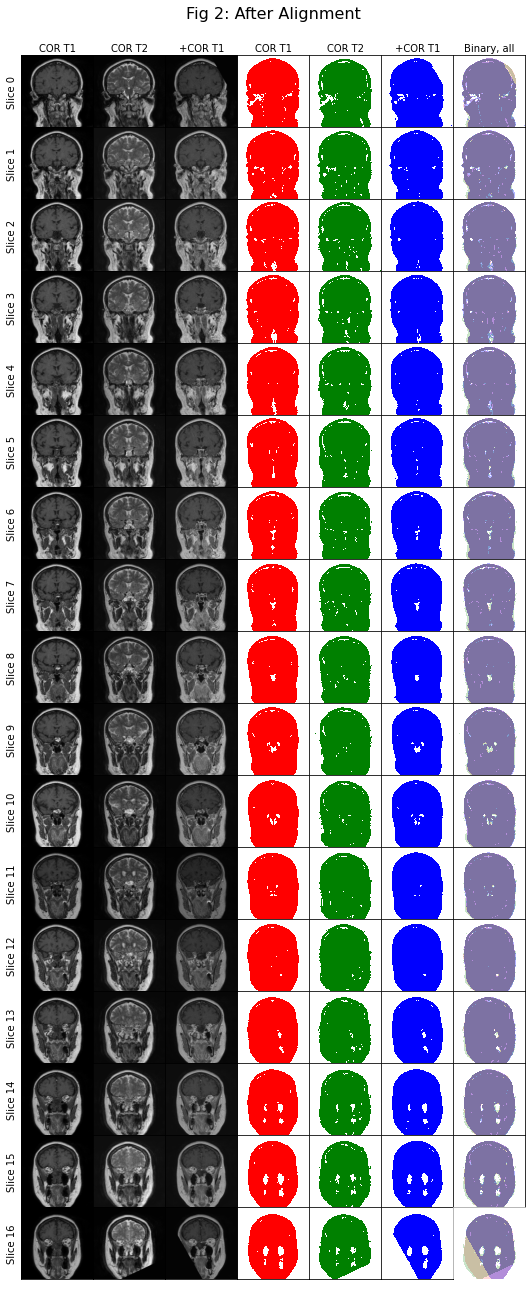

In [28]:
ncols = len(ims) + len(ims) + 1
nrows = nslices

# fig options
fig_mult = 1
options = {
    "wspace": 0.0,
    "hspace": 0.0,
}

fig = plt.figure(figsize=(fig_mult*(ncols+1), fig_mult*(nrows+1))) 
gs  = gridspec.GridSpec(nrows, ncols,
        wspace=options["wspace"], hspace=options["hspace"], 
        top=1.-0.5/(nrows+1), bottom=0.5/(nrows+1), 
        left=0.5/(ncols+1), right=1-0.5/(ncols+1)) 
    
for row_idx, slice_idx in enumerate(range(nslices)):
    for col_idx, im_arr in enumerate(aligned_ims):
        im = np.take(im_arr, slice_idx, axis=axis)
        
        # plot original slice
        ax = plt.subplot(gs[row_idx,col_idx])
        ax.imshow(np.rot90(im), cmap=plt.cm.gray)
        
        # plot binary cmaps
        ax_next = plt.subplot(gs[row_idx,col_idx+len(ims)])
        ax_next.imshow(np.rot90(to_binary_im(im)), cmap=get_binary_cm(col2=seq_colors[col_idx]))
        
        # label the columns top of the plot
        if row_idx == 0:
            ax.set_xlabel(f'{seqs[col_idx]}')    
            ax.xaxis.set_label_position('top') 
            
            ax_next.set_xlabel(f'{seqs[col_idx]}')    
            ax_next.xaxis.set_label_position('top') 
       
        if col_idx == 0:
            # label the rows on the left side of the plot
            ax.set_ylabel(f'Slice {row_idx}')    
            ax.yaxis.set_label_position('left') 
            
        # remove tick marks
        ax.set_xticks([])
        ax.set_yticks([])
        
        ax_next.set_xticks([])
        ax_next.set_yticks([])
        
# plot last col w/ all binary maps overlaid
for row_idx, slice_idx in enumerate(range(nslices)):
        
        im_slices = [np.take(to_binary_im(im_arr), slice_idx, axis=axis) for im_arr in aligned_ims]
        
        # plot next col
        ax = plt.subplot(gs[row_idx,len(aligned_ims)+len(aligned_ims)])
            
        for im_slice, col in zip(im_slices, seq_colors):
            ax.imshow(np.rot90(im_slice), cmap=get_binary_cm(col2=col), alpha=0.3)
        
            if row_idx == 0:
                ax.set_xlabel(f'Binary, all')    
                ax.xaxis.set_label_position('top') 
            
            # remove tick marks
            ax.set_xticks([])
            ax.set_yticks([])
            
fig.suptitle('Fig 2: After Alignment', y=1.01, fontsize=16)
plt.axis('off')

In [15]:
moving_seqs

['COR T2', '+COR T1']

In [29]:
# Compare before-and-after

col_names = ["COR T1", "COR T2", "Aligned COR T2", "+COR T1", "Aligned +COR T1"]

unaligned_ims = {seq: get_arr(seq) for seq in seqs}
aligned_ims   = {f"Aligned {moving_seq}": get_aligned_arr(moving_seq) for moving_seq in moving_seqs}

ims_dict = {**unaligned_ims, **aligned_ims}
col_ims = [ims_dict[seq] for seq in col_names]

(-0.5, 511.5, 511.5, -0.5)

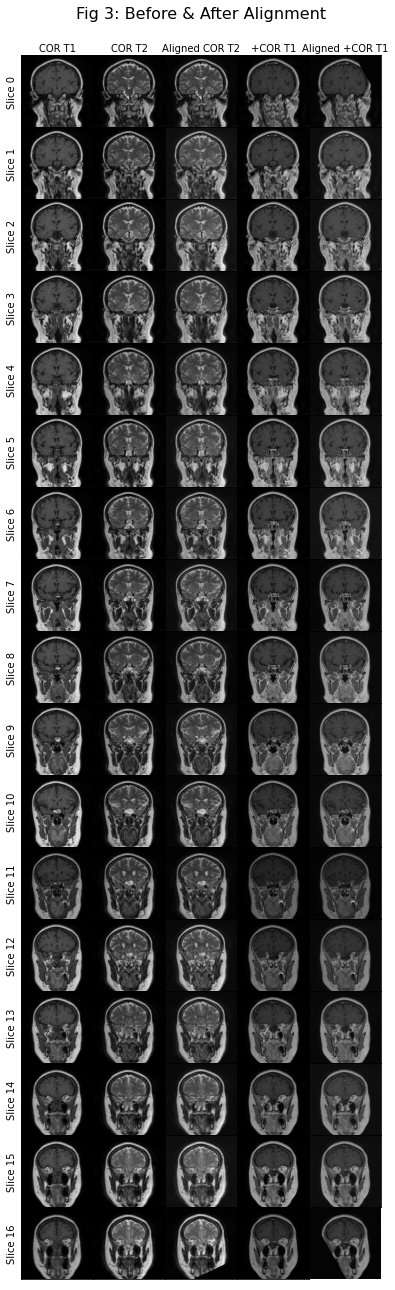

In [30]:
ncols = len(col_ims)
nrows = nslices

# fig options
fig_mult = 1
options = {
    "wspace": 0.0,
    "hspace": 0.0,
}

fig = plt.figure(figsize=(fig_mult*(ncols+1), fig_mult*(nrows+1))) 
gs  = gridspec.GridSpec(nrows, ncols,
        wspace=options["wspace"], hspace=options["hspace"], 
        top=1.-0.5/(nrows+1), bottom=0.5/(nrows+1), 
        left=0.5/(ncols+1), right=1-0.5/(ncols+1)) 
    
for row_idx, slice_idx in enumerate(range(nslices)):
    for col_idx, im_arr in enumerate(col_ims):
        im = np.take(im_arr, slice_idx, axis=axis)
        
        # plot original slice
        ax = plt.subplot(gs[row_idx,col_idx])
        ax.imshow(np.rot90(im), cmap=plt.cm.gray)
        
        # label the columns top of the plot
        if row_idx == 0:
            ax.set_xlabel(f'{col_names[col_idx]}')    
            ax.xaxis.set_label_position('top') 
       
        if col_idx == 0:
            # label the rows on the left side of the plot
            ax.set_ylabel(f'Slice {row_idx}')    
            ax.yaxis.set_label_position('left') 
            
        # remove tick marks
        ax.set_xticks([])
        ax.set_yticks([])
        
        ax_next.set_xticks([])
        ax_next.set_yticks([])

fig.suptitle('Fig 3: Before & After Alignment', y=1.01, fontsize=16)
plt.axis('off')

In [ ]:
# im_arr = ims[0]
# interact(explore_3dimage, 
#          layer0=(0, im_arr.shape[0] - 1), 
#          layer1=(0, im_arr.shape[1] - 1), 
#          layer2=(0, im_arr.shape[2] - 1),
#          im_arr=fixed(im_arr));